In [2]:
import pandas as pd
import numpy as np
import datetime
import copy
import numpy
import random

from collections import deque

C:\Users\KIMJINU\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\KIMJINU\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\KIMJINU\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [24]:
pt_tmp=pd.read_excel("JSP_dataset_case.xlsx",sheet_name="Processing Time",index_col =[0])
ms_tmp=pd.read_excel("JSP_dataset_case.xlsx",sheet_name="Machines Sequence",index_col =[0])

start_time = datetime.datetime.strptime("2022-01-01 14:44", "%Y-%m-%d %H:%M")
moving_time = 0.1
Capa_utilization_rate =  0.715 
max_process=len(pt_tmp.columns)
num_job=len(pt_tmp)
#num_mc=7
L_num = 8
M_num = 3
R_num = 2
G_num = 5
CNC_num = 1
MCT_num = 7
B_num = 7
num_mc = L_num+M_num+R_num+G_num+CNC_num+MCT_num+B_num
num_gene=max_process*num_job - pt_tmp.isnull().sum().sum() 

pt=[list(map(float,pt_tmp.iloc[i][0:max_process-pt_tmp.iloc[i].isnull().sum()])) for i in range(num_job)]
ms=[list(map(float,ms_tmp.iloc[i][0:max_process-ms_tmp.iloc[i].isnull().sum()])) for i in range(num_job)]

population_size = 50
crossover_rate = 0.8
mutation_rate = 0.8
mutation_selection_rate = 0.5
num_mutation_jobs = round(num_gene*mutation_selection_rate)
generation = 1000


Tbest=999999999999999
current_time = datetime.datetime.now()

In [25]:
# LPT
# Data
data = []
job_flow = []
LPT_IP = []

for i in range(len(pt)):
    data.append([])
    for j in range(len(pt[i])) : 
        if j == 0 :
            past_job_is_done = True
        else:
            past_job_is_done = False
        data[i].append([pt[i][j],ms[i][j],i,j,past_job_is_done])
        job_flow.append([pt[i][j],ms[i][j],i,j,past_job_is_done])

job_flow_sorted = sorted(job_flow, key = lambda x : (x[4], x[0])) # LPT 정렬기준

L_job = []
L_done = []

for i in range(L_num) :
    L_job.append(deque([]))
    L_done.append(dict(task = "L-"+ str(i+1), last_time = start_time, process = []))
    
    
M_job = []
M_done = []
for i in range(M_num) :
    M_job.append(deque([]))
    M_done.append(dict(task = "M-"+ str(i+1), last_time = start_time, process = []))

R_job = []
R_done = []
for i in range(R_num) :
    R_job.append(deque([]))
    R_done.append(dict(task = "R-"+ str(i+1), last_time = start_time, process = []))
    

G_job = []
G_done = []
for i in range(G_num) :
    G_job.append(deque([]))
    G_done.append(dict(task = "G-"+ str(i+1), last_time = start_time, process = []))

CNC_job = []
CNC_done = []
for i in range(CNC_num) :
    CNC_job.append(deque([]))
    CNC_done.append(dict(task = "CNC-"+ str(i+1), last_time = start_time, process = []))
    
MCT_job = []
MCT_done = []
for i in range(MCT_num) :
    MCT_job.append(deque([]))
    MCT_done.append(dict(task = "MCT-"+ str(i+1), last_time = start_time, process = []))

B_job = []
B_done = []
for i in range(B_num) :
    B_job.append(deque([]))
    B_done.append(dict(task = "B-"+ str(i+1), last_time = start_time, process = []))

jobs_done = [L_done] + [M_done] + [R_done] + [G_done] + [CNC_done] + [MCT_done] + [B_done]

process_done = pd.DataFrame([],columns=['Machine', 'Start', 'Finish'])
process_done['Start'] = pd.to_datetime(process_done['Start'])
process_done['Finish'] = pd.to_datetime(process_done['Finish'])

# [0.8, 2.0, 26, 0, True]
process_done = []

while job_flow_sorted :
    current_job = job_flow_sorted.pop()
    for job in job_flow_sorted : 
        if (job[2] == current_job[2]) and (job[3]==current_job[3]+1) : 
            job[4] = True
    current_process = current_job[1]
    min_time = datetime.datetime.strptime("2030-01-01 14:44", "%Y-%m-%d %H:%M")
    done_time = datetime.datetime.strptime("2022-01-01 14:44", "%Y-%m-%d %H:%M")
    min_task_id = -1
    # task의 마지막 done time이 같을 경우 id가 제일 빠른 machine을 채택한다.
    current_machine = jobs_done[int(current_process)-1]

    # process의 앞 단계가 끝나지 않았는데 job에 들어가면 안되기 때문에 해당 logic이 필요함.
    all_more_done = True
    if process_done :
        for process in process_done:
                if process['location'] == (current_job[2], current_job[3]-1):
                    done_time = process['Finish']
                    break

        for i, task in enumerate(current_machine) :
            # 여러 개의 task가 done_time보다 같거나 일찍 끝나면 위에서 부터 아무거나 선택
            if (task['last_time'] <= done_time) :
                min_time = done_time
                min_task_id = i
                all_more_done = False
                break

        if all_more_done :
            for i, task in enumerate(current_machine) :
                ## 이런 조건이 없을 경우에 그냥 last_time이 done_time보다 큰 것 아무거나 골라서 job에 할당한다
                if task['last_time'] < min_time :
                    min_time = task['last_time']
                    min_task_id = i

    else : 
        for i, task in enumerate(current_machine) :
            if task['last_time'] <= min_time :
                min_time = task['last_time']
                min_task_id = i



    
    if current_machine[min_task_id]['last_time'] == datetime.datetime.strptime("2022-01-01 14:44", "%Y-%m-%d %H:%M"):
       current_machine[min_task_id]['last_time'] += datetime.timedelta(hours = current_job[0] / Capa_utilization_rate)
       current_machine[min_task_id]['process'].append((current_job[2], current_job[3]))
       process_done.append(dict(Machine = current_machine[min_task_id]['task'], Start = min_time, \
        Finish = current_machine[min_task_id]['last_time'], location = (current_job[2], current_job[3])))
    
    else : 
        rest_time = min_time - current_machine[min_task_id]['last_time']
        if rest_time <= datetime.timedelta(hours = moving_time):
            current_machine[min_task_id]['last_time'] = min_time + datetime.timedelta(hours = moving_time) - rest_time + datetime.timedelta(hours = current_job[0] / Capa_utilization_rate)
            current_machine[min_task_id]['process'].append((current_job[2], current_job[3]))
            process_done.append(dict(Machine = current_machine[min_task_id]['task'], Start = min_time + datetime.timedelta(hours = moving_time), \
                Finish = current_machine[min_task_id]['last_time'], location = (current_job[2], current_job[3])))
        else : 
            current_machine[min_task_id]['last_time'] = min_time + datetime.timedelta(hours = current_job[0] / Capa_utilization_rate)
            current_machine[min_task_id]['process'].append((current_job[2], current_job[3]))
            process_done.append(dict(Machine = current_machine[min_task_id]['task'], Start = min_time + datetime.timedelta(hours = moving_time), \
                Finish = current_machine[min_task_id]['last_time'], location = (current_job[2], current_job[3])))
    
    job_flow_sorted = sorted(job_flow_sorted, key = lambda x : (x[4], x[0]))
    
df = pd.DataFrame( [d for d in process_done])

for i in range(len(df)):
    LPT_IP.append(df.iloc[i]['location'][0])

In [26]:
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
L_keys=["1"+"_"+str(j+1) for j in range(L_num)]
M_keys=["2"+"_"+str(j+1) for j in range(M_num)]
R_keys=["3"+"_"+str(j+1) for j in range(R_num)]
G_keys=["4"+"_"+str(j+1) for j in range(G_num)]
CNC_keys=["5"+"_"+str(j+1) for j in range(CNC_num)]
MCT_keys=["6"+"_"+str(j+1) for j in range(MCT_num)]
B_keys=["7"+"_"+str(j+1) for j in range(B_num)]
m_keys = L_keys+M_keys+R_keys+G_keys+CNC_keys+MCT_keys+B_keys
m_count={key:0 for key in m_keys}

for i in LPT_IP:
    gen_t=float(pt[i][key_count[i]])/Capa_utilization_rate
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t+moving_time
    L_min = 9999999
    M_min = 9999999
    R_min = 9999999
    G_min = 9999999
    CNC_min = 9999999
    MCT_min = 9999999
    B_min = 9999999

    if gen_m == 1:
        for k in range(1,L_num+1):
            L_temp = m_count["1_"+str(k)]
            if L_temp < L_min:
                L_min = L_temp
                index = "1_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 2:
        for k in range(1,M_num+1):
            M_temp = m_count["2_"+str(k)]
            if M_temp < M_min:
                M_min = M_temp
                index = "2_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 3:
        for k in range(1,R_num+1):
            R_temp = m_count["3_"+str(k)]
            if R_temp < R_min:
                R_min = R_temp
                index = "3_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 4:
        for k in range(1,G_num+1):
            G_temp = m_count["4_"+str(k)]
            if G_temp < G_min:
                G_min = G_temp
                index = "4_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 5:
        for k in range(1,CNC_num+1):
            CNC_temp = m_count["5_"+str(k)]
            if CNC_temp < CNC_min:
                CNC_min = CNC_temp
                index = "5_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 6:
        for k in range(1,MCT_num+1):
            MCT_temp = m_count["6_"+str(k)]
            if MCT_temp < MCT_min:
                MCT_min = MCT_temp
                index = "6_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    else:
        for k in range(1,B_num+1):
            B_temp = m_count["7_"+str(k)]
            if B_temp < B_min:
                B_min = B_temp
                index = "7_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    if m_count[index]<j_count[i]:
        m_count[index]=j_count[i]
    elif m_count[index]>j_count[i]:
        j_count[i]=m_count[index]

    key_count[i]=key_count[i]+1

makespan_LPT=max(j_count.values())

In [27]:
print("optimal value:%f"%makespan_LPT)
print('End time:%s'%(str(start_time + datetime.timedelta(hours=makespan_LPT))))

optimal value:986.613986
End time:2022-02-11 17:20:50.349650


In [28]:
# SPT
# Data
data = []
job_flow = []
SPT_IP = []

for i in range(len(pt)):
    data.append([])
    for j in range(len(pt[i])) : 
        if j == 0 :
            past_job_is_done = True
        else:
            past_job_is_done = False
        data[i].append([pt[i][j],ms[i][j],i,j,past_job_is_done])
        job_flow.append([pt[i][j],ms[i][j],i,j,past_job_is_done])

job_flow_sorted = sorted(job_flow, key = lambda x : (x[4], -x[0])) # SPT 정렬기준

L_job = []
L_done = []

for i in range(L_num) :
    L_job.append(deque([]))
    L_done.append(dict(task = "L-"+ str(i+1), last_time = start_time, process = []))
    
    
M_job = []
M_done = []
for i in range(M_num) :
    M_job.append(deque([]))
    M_done.append(dict(task = "M-"+ str(i+1), last_time = start_time, process = []))

R_job = []
R_done = []
for i in range(R_num) :
    R_job.append(deque([]))
    R_done.append(dict(task = "R-"+ str(i+1), last_time = start_time, process = []))
    

G_job = []
G_done = []
for i in range(G_num) :
    G_job.append(deque([]))
    G_done.append(dict(task = "G-"+ str(i+1), last_time = start_time, process = []))

CNC_job = []
CNC_done = []
for i in range(CNC_num) :
    CNC_job.append(deque([]))
    CNC_done.append(dict(task = "CNC-"+ str(i+1), last_time = start_time, process = []))
    
MCT_job = []
MCT_done = []
for i in range(MCT_num) :
    MCT_job.append(deque([]))
    MCT_done.append(dict(task = "MCT-"+ str(i+1), last_time = start_time, process = []))

B_job = []
B_done = []
for i in range(B_num) :
    B_job.append(deque([]))
    B_done.append(dict(task = "B-"+ str(i+1), last_time = start_time, process = []))

jobs_done = [L_done] + [M_done] + [R_done] + [G_done] + [CNC_done] + [MCT_done] + [B_done]

process_done = pd.DataFrame([],columns=['Machine', 'Start', 'Finish'])
process_done['Start'] = pd.to_datetime(process_done['Start'])
process_done['Finish'] = pd.to_datetime(process_done['Finish'])

# [0.8, 2.0, 26, 0, True]
process_done = []

while job_flow_sorted :
    current_job = job_flow_sorted.pop()
    for job in job_flow_sorted : 
        if (job[2] == current_job[2]) and (job[3]==current_job[3]+1) : 
            job[4] = True
    current_process = current_job[1]
    min_time = datetime.datetime.strptime("2030-01-01 14:44", "%Y-%m-%d %H:%M")
    done_time = datetime.datetime.strptime("2022-01-01 14:44", "%Y-%m-%d %H:%M")
    min_task_id = -1
    # task의 마지막 done time이 같을 경우 id가 제일 빠른 machine을 채택한다.
    current_machine = jobs_done[int(current_process)-1]

    # process의 앞 단계가 끝나지 않았는데 job에 들어가면 안되기 때문에 해당 logic이 필요함.
    all_more_done = True
    if process_done :
        for process in process_done:
                if process['location'] == (current_job[2], current_job[3]-1):
                    done_time = process['Finish']
                    break

        for i, task in enumerate(current_machine) :
            # 여러 개의 task가 done_time보다 같거나 일찍 끝나면 위에서 부터 아무거나 선택
            if (task['last_time'] <= done_time) :
                min_time = done_time
                min_task_id = i
                all_more_done = False
                break

        if all_more_done :
            for i, task in enumerate(current_machine) :
                ## 이런 조건이 없을 경우에 그냥 last_time이 done_time보다 큰 것 아무거나 골라서 job에 할당한다
                if task['last_time'] < min_time :
                    min_time = task['last_time']
                    min_task_id = i

    else : 
        for i, task in enumerate(current_machine) :
            if task['last_time'] <= min_time :
                min_time = task['last_time']
                min_task_id = i



    
    if current_machine[min_task_id]['last_time'] == datetime.datetime.strptime("2022-01-01 14:44", "%Y-%m-%d %H:%M"):
       current_machine[min_task_id]['last_time'] += datetime.timedelta(hours = current_job[0] / Capa_utilization_rate)
       current_machine[min_task_id]['process'].append((current_job[2], current_job[3]))
       process_done.append(dict(Machine = current_machine[min_task_id]['task'], Start = min_time, \
        Finish = current_machine[min_task_id]['last_time'], location = (current_job[2], current_job[3])))
    
    else : 
        rest_time = min_time - current_machine[min_task_id]['last_time']
        if rest_time <= datetime.timedelta(hours = moving_time):
            current_machine[min_task_id]['last_time'] = min_time + datetime.timedelta(hours = moving_time) - rest_time + datetime.timedelta(hours = current_job[0] / Capa_utilization_rate)
            current_machine[min_task_id]['process'].append((current_job[2], current_job[3]))
            process_done.append(dict(Machine = current_machine[min_task_id]['task'], Start = min_time + datetime.timedelta(hours = moving_time), \
                Finish = current_machine[min_task_id]['last_time'], location = (current_job[2], current_job[3])))
        else : 
            current_machine[min_task_id]['last_time'] = min_time + datetime.timedelta(hours = current_job[0] / Capa_utilization_rate)
            current_machine[min_task_id]['process'].append((current_job[2], current_job[3]))
            process_done.append(dict(Machine = current_machine[min_task_id]['task'], Start = min_time + datetime.timedelta(hours = moving_time), \
                Finish = current_machine[min_task_id]['last_time'], location = (current_job[2], current_job[3])))
    
    job_flow_sorted = sorted(job_flow_sorted, key = lambda x : (x[4], -x[0]))
    
df = pd.DataFrame( [d for d in process_done])

for i in range(len(df)):
    SPT_IP.append(df.iloc[i]['location'][0])

In [29]:
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
L_keys=["1"+"_"+str(j+1) for j in range(L_num)]
M_keys=["2"+"_"+str(j+1) for j in range(M_num)]
R_keys=["3"+"_"+str(j+1) for j in range(R_num)]
G_keys=["4"+"_"+str(j+1) for j in range(G_num)]
CNC_keys=["5"+"_"+str(j+1) for j in range(CNC_num)]
MCT_keys=["6"+"_"+str(j+1) for j in range(MCT_num)]
B_keys=["7"+"_"+str(j+1) for j in range(B_num)]
m_keys = L_keys+M_keys+R_keys+G_keys+CNC_keys+MCT_keys+B_keys
m_count={key:0 for key in m_keys}

for i in SPT_IP:
    gen_t=float(pt[i][key_count[i]])/Capa_utilization_rate
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t+moving_time
    L_min = 9999999
    M_min = 9999999
    R_min = 9999999
    G_min = 9999999
    CNC_min = 9999999
    MCT_min = 9999999
    B_min = 9999999

    if gen_m == 1:
        for k in range(1,L_num+1):
            L_temp = m_count["1_"+str(k)]
            if L_temp < L_min:
                L_min = L_temp
                index = "1_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 2:
        for k in range(1,M_num+1):
            M_temp = m_count["2_"+str(k)]
            if M_temp < M_min:
                M_min = M_temp
                index = "2_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 3:
        for k in range(1,R_num+1):
            R_temp = m_count["3_"+str(k)]
            if R_temp < R_min:
                R_min = R_temp
                index = "3_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 4:
        for k in range(1,G_num+1):
            G_temp = m_count["4_"+str(k)]
            if G_temp < G_min:
                G_min = G_temp
                index = "4_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 5:
        for k in range(1,CNC_num+1):
            CNC_temp = m_count["5_"+str(k)]
            if CNC_temp < CNC_min:
                CNC_min = CNC_temp
                index = "5_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 6:
        for k in range(1,MCT_num+1):
            MCT_temp = m_count["6_"+str(k)]
            if MCT_temp < MCT_min:
                MCT_min = MCT_temp
                index = "6_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    else:
        for k in range(1,B_num+1):
            B_temp = m_count["7_"+str(k)]
            if B_temp < B_min:
                B_min = B_temp
                index = "7_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    if m_count[index]<j_count[i]:
        m_count[index]=j_count[i]
    elif m_count[index]>j_count[i]:
        j_count[i]=m_count[index]

    key_count[i]=key_count[i]+1

makespan_SPT=max(j_count.values())

In [30]:
print("optimal value:%f"%makespan_SPT)
print('End time:%s'%(str(start_time + datetime.timedelta(hours=makespan_SPT))))

optimal value:1098.423077
End time:2022-02-16 09:09:23.076923


In [59]:
# GA
best_list,best_obj=[],[]
population_list=[]
makespan_record=[]
for i in range(int(population_size*0.8)):
    nxm_random_num=list(np.random.permutation(num_gene)) 
    population_list.append(nxm_random_num) 
    for j in range(num_gene):
        population_list[i][j]=population_list[i][j]%num_job 
        
for i in range(int(population_size*0.1)):
    population_list.append(LPT_IP)
    population_list.append(SPT_IP)

In [60]:
for generation_num in range(1,generation+1):
    print(generation_num)
    Tbest_now=99999999999         
    
    for m in range(population_size):
        job_count={}
        larger,less=[],[]
        for i in range(num_job):
            process_num_i = len(ms_tmp.iloc[i]) - ms_tmp.iloc[i].isnull().sum()
            if i in population_list[m]:
                count=population_list[m].count(i)
                pos=population_list[m].index(i)
                job_count[i]=[count,pos]
            else:
                count=0
                job_count[i]=[count,0]

            if count>process_num_i:
                larger.append(i)
            elif count<process_num_i:
                less.append(i)

        for k in range(len(larger)):
            chg_job=larger[k]
            process_num_chg_job = len(ms_tmp.iloc[chg_job]) - ms_tmp.iloc[chg_job].isnull().sum()
            while job_count[chg_job][0]>process_num_chg_job:
                for d in range(len(less)):

                    process_num_d = len(ms_tmp.iloc[less[d]]) - ms_tmp.iloc[less[d]].isnull().sum()
                    if job_count[less[d]][0]<process_num_d:       
                        population_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=population_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==process_num_chg_job:
                        break

    parent_list=copy.deepcopy(population_list)
    offspring_list=copy.deepcopy(population_list)
    S=list(np.random.permutation(population_size))
    
    for m in range(int(population_size/2)):
        crossover_prob=np.random.rand()
        if crossover_rate>=crossover_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]
            cutpoint=list(np.random.choice(num_gene, 2, replace=False))
            cutpoint.sort()

            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
                        
                        
                        
    for m in range(population_size):
        job_count={}
        larger,less=[],[]
        for i in range(num_job):
            process_num_i = len(ms_tmp.iloc[i]) - ms_tmp.iloc[i].isnull().sum()
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos]
            else:
                count=0
                job_count[i]=[count,0]

            if count>process_num_i:
                larger.append(i)
            elif count<process_num_i:
                less.append(i)

        for k in range(len(larger)):
            chg_job=larger[k]
            process_num_chg_job = len(ms_tmp.iloc[chg_job]) - ms_tmp.iloc[chg_job].isnull().sum()
            while job_count[chg_job][0]>process_num_chg_job:
                for d in range(len(less)):
                    process_num_d = len(ms_tmp.iloc[less[d]]) - ms_tmp.iloc[less[d]].isnull().sum()
                    if job_count[less[d]][0]<process_num_d:       
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==process_num_chg_job:
                        break

    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate >= mutation_prob:
            m_chg=list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) 
            t_value_last=offspring_list[m][m_chg[0]] 
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]]

            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last

    
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list)
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        L_keys=["1"+"_"+str(j+1) for j in range(L_num)]
        M_keys=["2"+"_"+str(j+1) for j in range(M_num)]
        R_keys=["3"+"_"+str(j+1) for j in range(R_num)]
        G_keys=["4"+"_"+str(j+1) for j in range(G_num)]
        CNC_keys=["5"+"_"+str(j+1) for j in range(CNC_num)]
        MCT_keys=["6"+"_"+str(j+1) for j in range(MCT_num)]
        B_keys=["7"+"_"+str(j+1) for j in range(B_num)]
        m_keys = L_keys+M_keys+R_keys+G_keys+CNC_keys+MCT_keys+B_keys
        m_count={key:0 for key in m_keys}

        for i in total_chromosome[m]:
            gen_t=float(pt[i][key_count[i]])/Capa_utilization_rate
            gen_m=int(ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t+moving_time
            L_min = 9999999
            M_min = 9999999
            R_min = 9999999
            G_min = 9999999
            CNC_min = 9999999
            MCT_min = 9999999
            B_min = 9999999

            if gen_m == 1:
                for k in range(1,L_num+1):
                    L_temp = m_count["1_"+str(k)]
                    if L_temp < L_min:
                        L_min = L_temp
                        index = "1_"+str(k)
                    else:
                        continue
                m_count[index]=m_count[index]+gen_t

            elif gen_m == 2:
                for k in range(1,M_num+1):
                    M_temp = m_count["2_"+str(k)]
                    if M_temp < M_min:
                        M_min = M_temp
                        index = "2_"+str(k)
                    else:
                        continue
                m_count[index]=m_count[index]+gen_t

            elif gen_m == 3:
                for k in range(1,R_num+1):
                    R_temp = m_count["3_"+str(k)]
                    if R_temp < R_min:
                        R_min = R_temp
                        index = "3_"+str(k)
                    else:
                        continue
                m_count[index]=m_count[index]+gen_t

            elif gen_m == 4:
                for k in range(1,G_num+1):
                    G_temp = m_count["4_"+str(k)]
                    if G_temp < G_min:
                        G_min = G_temp
                        index = "4_"+str(k)
                    else:
                        continue
                m_count[index]=m_count[index]+gen_t

            elif gen_m == 5:
                for k in range(1,CNC_num+1):
                    CNC_temp = m_count["5_"+str(k)]
                    if CNC_temp < CNC_min:
                        CNC_min = CNC_temp
                        index = "5_"+str(k)
                    else:
                        continue
                m_count[index]=m_count[index]+gen_t

            elif gen_m == 6:
                for k in range(1,MCT_num+1):
                    MCT_temp = m_count["6_"+str(k)]
                    if MCT_temp < MCT_min:
                        MCT_min = MCT_temp
                        index = "6_"+str(k)
                    else:
                        continue
                m_count[index]=m_count[index]+gen_t

            else:
                for k in range(1,B_num+1):
                    B_temp = m_count["7_"+str(k)]
                    if B_temp < B_min:
                        B_min = B_temp
                        index = "7_"+str(k)
                    else:
                        continue
                m_count[index]=m_count[index]+gen_t

            if m_count[index]<j_count[i]:
                m_count[index]=j_count[i]
            elif m_count[index]>j_count[i]:
                j_count[i]=m_count[index]

            key_count[i]=key_count[i]+1

        makespan=max(j_count.values())
        chrom_fitness.append(1/makespan)
        chrom_fit.append(makespan)
        total_fitness=total_fitness+chrom_fitness[m]

    pk,qk=[],[]

    for i in range(population_size*2):
        pk.append(chrom_fitness[i]/total_fitness)
    for i in range(population_size*2):
        cumulative=0
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)

    selection_rand=[np.random.rand() for i in range(population_size)]

    for i in range(population_size):
        if selection_rand[i]<=qk[0]:
            population_list[i]=copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0,population_size*2-1):
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break

    for i in range(population_size*2):
        if chrom_fit[i]<Tbest_now:
            Tbest_now=chrom_fit[i]
            sequence_now=copy.deepcopy(total_chromosome[i])

    if Tbest_now<=Tbest:
        Tbest=Tbest_now
        sequence_best=copy.deepcopy(sequence_now)

    makespan_record.append(Tbest)

1
2
3
4
5
6
7
8
9
10


In [61]:
'''----------result----------'''
print("optimal sequence",sequence_best)
print("optimal value:%f"%Tbest)
print('End time:%s'%(str(start_time + datetime.timedelta(hours=Tbest))))
print('the elapsed time:%s'% (datetime.datetime.now() - current_time))

optimal sequence [82, 15, 19, 101, 57, 35, 104, 8, 1, 34, 59, 57, 16, 55, 44, 36, 107, 80, 10, 40, 116, 75, 115, 84, 36, 6, 109, 32, 16, 64, 8, 96, 53, 27, 22, 14, 1, 53, 2, 70, 70, 61, 87, 105, 45, 25, 61, 73, 9, 104, 67, 71, 61, 77, 65, 54, 85, 113, 103, 26, 88, 94, 112, 100, 17, 59, 105, 15, 99, 88, 110, 17, 18, 107, 112, 54, 62, 41, 72, 24, 58, 109, 35, 82, 5, 80, 93, 115, 64, 115, 35, 110, 94, 116, 1, 13, 83, 24, 103, 12, 26, 37, 65, 98, 42, 116, 67, 27, 92, 44, 99, 20, 20, 85, 49, 56, 13, 111, 97, 99, 68, 77, 56, 73, 18, 49, 81, 91, 108, 99, 36, 79, 50, 106, 32, 23, 101, 25, 53, 55, 95, 21, 60, 116, 11, 117, 28, 31, 112, 24, 103, 108, 119, 32, 43, 21, 100, 42, 105, 111, 89, 37, 12, 94, 48, 97, 37, 72, 23, 58, 38, 90, 42, 22, 38, 74, 27, 76, 85, 22, 59, 101, 109, 83, 47, 33, 96, 77, 53, 69, 34, 78, 89, 21, 94, 60, 63, 71, 107, 13, 72, 72, 101, 102, 108, 5, 66, 12, 104, 54, 7, 82, 33, 86, 17, 11, 45, 76, 48, 76, 4, 43, 114, 105, 115, 79, 51, 64, 81, 113, 62, 35, 93, 71, 63, 24, 93,

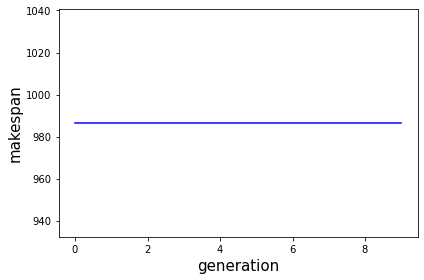

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
#plt.show()
plt.tight_layout()
plt.savefig('Makespan_fig.jpg')

In [103]:
import pandas as pd
import chart_studio.plotly as py
import plotly
import plotly.figure_factory

j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
L_keys=["1"+"_"+str(j+1) for j in range(L_num)]
M_keys=["2"+"_"+str(j+1) for j in range(M_num)]
R_keys=["3"+"_"+str(j+1) for j in range(R_num)]
G_keys=["4"+"_"+str(j+1) for j in range(G_num)]
CNC_keys=["5"+"_"+str(j+1) for j in range(CNC_num)]
MCT_keys=["6"+"_"+str(j+1) for j in range(MCT_num)]
B_keys=["7"+"_"+str(j+1) for j in range(B_num)]
m_keys = L_keys+M_keys+R_keys+G_keys+CNC_keys+MCT_keys+B_keys
m_count={key:0 for key in m_keys}
j_record={}
j_record_2={}

for i in sequence_best:
    gen_t=float(pt[i][key_count[i]])/Capa_utilization_rate
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t+moving_time
    L_min = 9999999
    M_min = 9999999
    R_min = 9999999
    G_min = 9999999
    CNC_min = 9999999
    MCT_min = 9999999
    B_min = 9999999

    if gen_m == 1:
        for k in range(1,L_num+1):
            L_temp = m_count["1_"+str(k)]
            if L_temp < L_min:
                L_min = L_temp
                index = "1_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 2:
        for k in range(1,M_num+1):
            M_temp = m_count["2_"+str(k)]
            if M_temp < M_min:
                M_min = M_temp
                index = "2_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 3:
        for k in range(1,R_num+1):
            R_temp = m_count["3_"+str(k)]
            if R_temp < R_min:
                R_min = R_temp
                index = "3_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 4:
        for k in range(1,G_num+1):
            G_temp = m_count["4_"+str(k)]
            if G_temp < G_min:
                G_min = G_temp
                index = "4_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 5:
        for k in range(1,CNC_num+1):
            CNC_temp = m_count["5_"+str(k)]
            if CNC_temp < CNC_min:
                CNC_min = CNC_temp
                index = "5_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    elif gen_m == 6:
        for k in range(1,MCT_num+1):
            MCT_temp = m_count["6_"+str(k)]
            if MCT_temp < MCT_min:
                MCT_min = MCT_temp
                index = "6_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t

    else:
        for k in range(1,B_num+1):
            B_temp = m_count["7_"+str(k)]
            if B_temp < B_min:
                B_min = B_temp
                index = "7_"+str(k)
            else:
                continue
        m_count[index]=m_count[index]+gen_t
    
    if m_count[index]<j_count[i]:
        m_count[index]=j_count[i]
    elif m_count[index]>j_count[i]:
        j_count[i]=m_count[index]
    
    current_time=datetime.timedelta(hours=j_count[i]-(pt[i][key_count[i]]/Capa_utilization_rate)) # convert seconds to hours, minutes and seconds
    end_time=datetime.timedelta(hours=j_count[i])
    try:
        j_record[(i,index)]
        j_record_2[(i,index)]=[current_time,end_time]
    except:
        j_record[(i,index)]=[current_time,end_time]
    #print(gen_m)
    
    key_count[i]=key_count[i]+1

df=[]

for (j,m) in j_record.keys():
    df.append(dict(Task='Machine %s'%(m), Start='%s'%(str(start_time + j_record[(j,m)][0])), Finish='%s'%(str(start_time + j_record[(j,m)][1])),Resource='Job %s'%(j+1)))

for (j,m) in j_record_2.keys():
    df.append(dict(Task='Machine %s'%(m), Start='%s'%(str(start_time + j_record_2[(j,m)][0])), Finish='%s'%(str(start_time + j_record_2[(j,m)][1])),Resource='Job %s'%(j+1)))
    
r = lambda: random.randint(0,255)            
colors = ['#%02X%02X%02X' % (r(),r(),r())]
for i in range(1, num_job):                                   
    colors.append('#%02X%02X%02X' % (r(),r(),r()))
    
    
    
fig = plotly.figure_factory.create_gantt(df, colors=colors,index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
fig.show()
plotly.io.write_image(fig,file="scheduling_fig.jpg", format="jpeg",scale=None, width=None, height=None)